In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tqdm
import pickle
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [2]:
from ase.neighborlist import neighbor_list

In [13]:
import atom_stat as astat

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [6]:
import utilities as utils

### When computing for damaged structures, atoms corresponding to the damaged region are considered.

In [9]:
%%time
# pka = 20000
# run = 4
# atoms = aio.read("xyz_05/cu_pka_{}_run_{}.xyz".format(pka, run))

atoms = utils.load_file("structs/dump.arc.10000_atom.pkl")

indexes = np.where(atoms.get_tags() != 1)[0]

print("No. of disturbed atoms: {}".format(len(indexes)))

coords_all = atoms.get_positions()
coords_sub = coords_all[indexes]

print(atoms.get_cell())

No. of disturbed atoms: 252704
Cell([362.950890120128, 362.950890120128, 362.950890120128])
CPU times: user 141 ms, sys: 241 ms, total: 381 ms
Wall time: 381 ms


### Compute RDF

In [10]:
atoms_big = atoms.repeat([3,3,3])
print(atoms_big.get_cell().diagonal())

indexes = np.where(atoms_big.get_tags() != 1)[0]
print(len(indexes))
coords_all_big = atoms_big.get_positions()
coords_sub_big = coords_all_big[indexes]

x_bot = np.array(atoms.get_cell().diagonal())
x_top = 2 * x_bot

c_list = []
for item in coords_sub_big:
    if np.all(item > x_bot) and np.all(item < x_top):
        c_list.append(item[None])
coords_sub_big = np.concatenate(c_list, axis=0)

print(len(coords_sub_big))

[1088.85267036 1088.85267036 1088.85267036]
6823008
252704


## $X(r) = \dfrac{n\left(r\right)}{\dfrac{4}{3}\pi(r_1^3 - r_0^3)n_0}$

In [11]:
r_stat = 50
len_pixel = 50
nbins = (r_stat+2)*len_pixel+1

In [ ]:
%%time
rdf, pdf = astat.get_rdf_tree(coords_all, coords_sub, cutoff=r_stat, nbins=nbins)

In [13]:
%%time
rdf_big, pdf_big = astat.get_rdf_tree(coords_all_big, coords_sub_big, cutoff=r_stat, nbins=nbins)

CPU times: user 37.1 s, sys: 1.67 s, total: 38.8 s
Wall time: 38.8 s


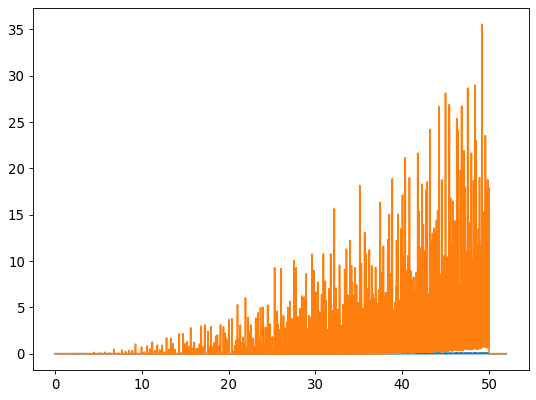

In [14]:
bins = np.linspace(0.0, r_stat+2, nbins)[1:]

plt.plot(bins, rdf_big/len(coords_sub))
plt.plot(bins, rdf_big-rdf)
# plt.plot(bins, rdf_np)
# plt.plot(bins, rdf)
plt.show()

### Visualize

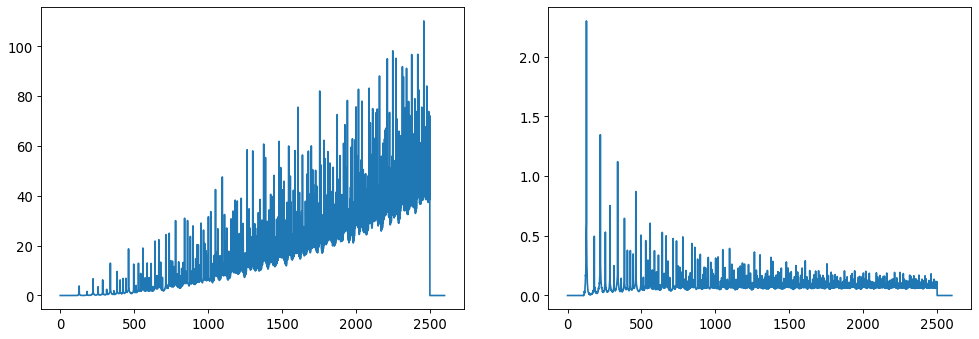

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))
ax[0].plot(rdf)
ax[1].plot(pdf[0:])
plt.show()

## Smoothening Protocol

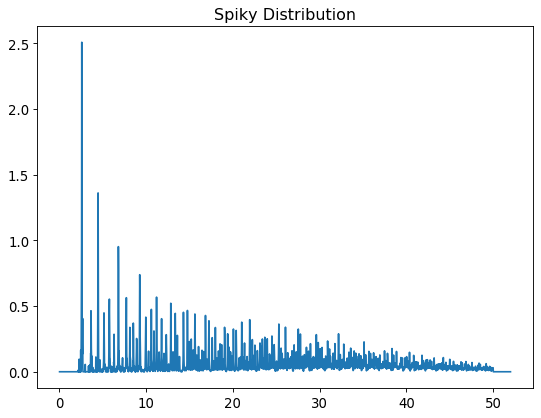

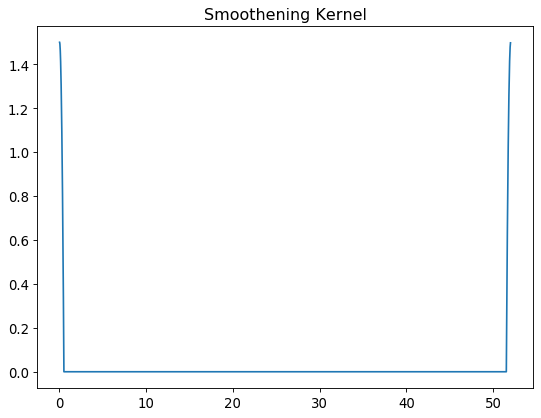

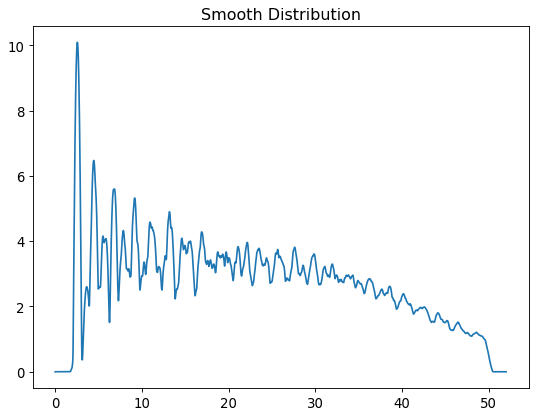

0.9696239999999982
142.15619977927017


In [13]:
bins = np.linspace(0.0, r_stat+2, nbins)[1:]

plt.plot(bins, pdf)
plt.title("Spiky Distribution")
plt.show()

kernel = astat.epanechnikov_kernel(width=0.5, x=bins)

plt.plot(bins, kernel)
plt.title("Smoothening Kernel")
plt.show()

new_pdf = astat.convolve_kernel(kernel, pdf)

plt.plot(bins, new_pdf)
plt.title("Smooth Distribution")
plt.show()

print(np.trapz(kernel, bins))
print(np.trapz(new_pdf, bins))

## Analysis over all structures

In [35]:
pka_list = [500, 1000, 2000, 5000, 10000, 20000, 50000]
nrun = 50
runs = np.arange(nrun)

In [48]:
r_stat = 50
len_pixel = 50
nbins = (r_stat+2)*len_pixel+1
bins = np.linspace(0.0, r_stat+2, nbins)[1:]
kernel = astat.epanechnikov_kernel(width=0.5, x=bins)

In [52]:
ix = 0

p_spiky = []
vols = []
n_atoms_all = []
n_atoms_irr = []

for pka in pka_list:
    for run in tqdm.tqdm_notebook(runs):
        
        atoms = aio.read("xyz_05/cu_pka_{}_run_{}.xyz".format(pka, run))
        idx = np.where(atoms.get_tags() != 1)[0]
        
        coords_all = atoms.get_positions()
        coords_sub = coords_all[idx]
        
        vols.append(atoms.get_volume())
        n_atoms_all.append(len(coords_all))
        n_atoms_irr.append(len(coords_sub))
               
#         atoms_big = atoms.repeat([3,3,3])
#         indexes = np.where(atoms_big.get_tags() != 1)[0]
#         if len(indexes) != 0:
#             coords_all_big = atoms_big.get_positions()
#             coords_sub_big = coords_all_big[indexes]
#             x_bot = np.array(atoms.get_cell().diagonal())
#             x_top = 2 * x_bot
#             c_list = []
#             for item in coords_sub_big:
#                 if np.all(item > x_bot) and np.all(item < x_top):
#                     c_list.append(item[None])
#             coords_sub_big = np.concatenate(c_list, axis=0)      

#             rdf, pdf = astat.get_rdf_tree(coords_all_big, coords_sub_big, cutoff=r_stat, nbins=nbins)

#             p_spiky.append(pdf)
#             ix += 1
        
# save_file("cu_rdf_spiky_01_periodic.pkl", p_spiky)

In [70]:
save_file("tot_atom_count_01.pkl", n_atoms_all)
save_file("irr_atom_count_01.pkl", n_atoms_irr)
save_file("box_volume.pkl", vols)

In [47]:
# save_file("cu_rdf_spiky_01.pkl", p_spiky)

## Analysis of RDF signals

In [22]:
p_spiky[0].shape

(2600,)

In [56]:
# p_spiky = load_file("cu_rdf_spiky_05.pkl")
p_spiky = load_file("cu_rdf_spiky_01_periodic.pkl")
kernel = astat.epanechnikov_kernel(width=0.5, x=bins)
p_smooth = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth.append(new_pdf)
    
kernel = astat.epanechnikov_kernel(width=1.0, x=bins)
p_smooth_1 = []
for pdf in p_spiky:
    new_pdf = astat.convolve_kernel(kernel, pdf)
    p_smooth_1.append(new_pdf)

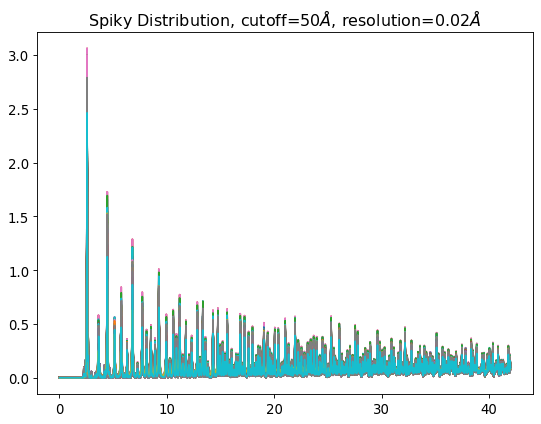

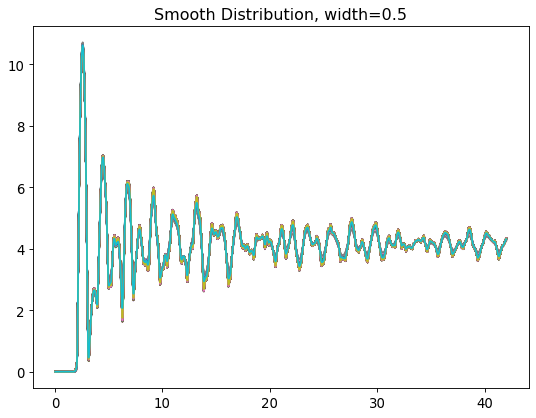

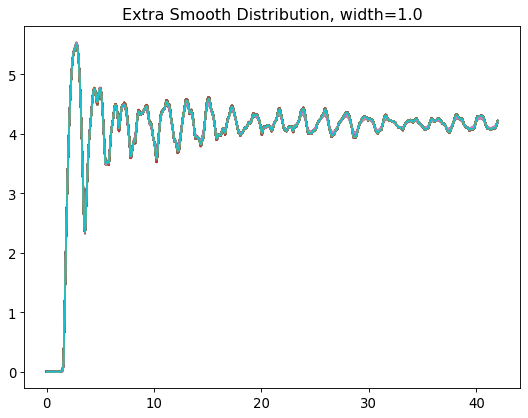

In [57]:
ix = 500
n_samples = 200
for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_spiky[i][:-ix])
plt.title("Spiky Distribution, cutoff={}$\AA$, resolution={}$\AA$".format(r_stat, 1/len_pixel))
plt.show()

for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_smooth[i][:-ix])
plt.title("Smooth Distribution, width=0.5")
plt.show()

for i in np.random.randint(0, len(p_spiky), n_samples):
    plt.plot(bins[:-ix], p_smooth_1[i][:-ix])
plt.title("Extra Smooth Distribution, width=1.0")
plt.show()

In [58]:
## RDF signlas containing NANs identified
indxs = np.where(np.any(np.isnan(p_smooth)==False, axis=1))[0]
print(len(indxs))

343


(343, 2100)
[0.90141231 0.04732989 0.01740496 0.0112137  0.00672659 0.00318528
 0.00266659 0.00188782 0.0016563  0.00105305]


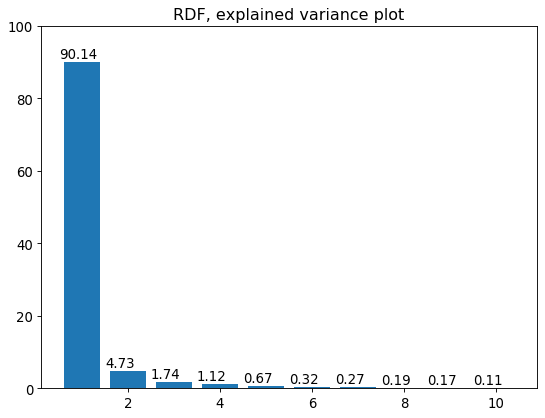

In [59]:
x_data = np.concatenate([item[None] for item in p_smooth_1], axis=0)
x_data = x_data[indxs][:,:-ix]
print(x_data.shape)

pca = PCA(n_components=10)
scores = pca.fit_transform(x_data)
print(pca.explained_variance_ratio_)

ex_var = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, 11), ex_var)
plt.ylim([0, 100])
for ix, item in enumerate(ex_var):
    plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
plt.title("RDF, explained variance plot")
plt.show()

In [60]:
pka_values = np.ravel([[item/1000]*nrun for item in pka_list])[indxs]
pka_labels = [str(item) for item in pka_values]

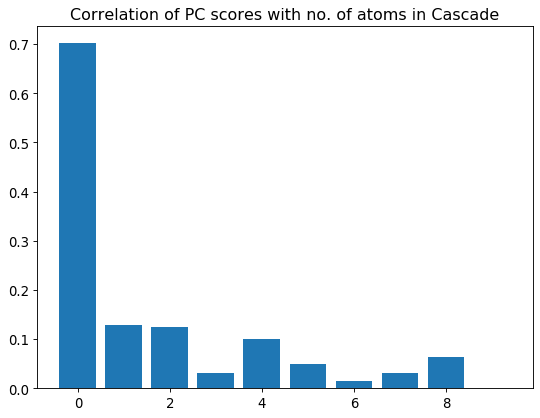

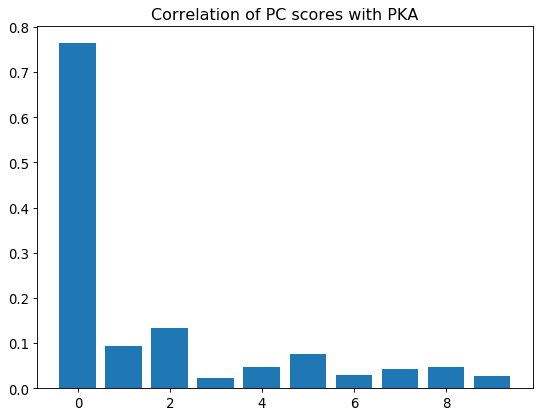

In [61]:
corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores[:,ix], np.asarray(n_atoms_irr)[indxs])[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of PC scores with no. of atoms in Cascade")
plt.show()


corrs = []
for ix in range(10):
    corrs.append(np.fabs(np.corrcoef(scores[:,ix], pka_values)[0,1]))
    
plt.bar(np.arange(10), corrs)
plt.title("Correlation of PC scores with PKA")
plt.show()

# corrs = []
# for ix in range(x_data.shape[1]):
#     corrs.append(np.fabs(np.corrcoef(scores[:,0], x_data[:,ix])[0,1]))
    
# plt.bar(bins, corrs)
# plt.title("Correlation of PC 1 with terms in the RDF")
# plt.show()

# corrs = []
# for ix in range(x_data.shape[1]):
#     corrs.append(np.fabs(np.corrcoef(scores[:,1], x_data[:,ix])[0,1]))
    
# plt.bar(bins, corrs)
# plt.title("Correlation of PC 2 with terms in the RDF")
# plt.show()

# corrs = []
# for ix in range(x_data.shape[1]):
#     corrs.append(np.fabs(np.corrcoef(scores[:,2], x_data[:,ix])[0,1]))
    
# plt.bar(bins, corrs)
# plt.title("Correlation of PC 3 with terms in the RDF")
# plt.show()


# corrs = []
# for ix in range(x_data.shape[1]):
#     corrs.append(np.fabs(np.corrcoef(scores[:,3], x_data[:,ix])[0,1]))
    
# plt.bar(bins, corrs)
# plt.title("Correlation of PC 4 with terms in the RDF")
# plt.show()


# corrs = []
# for ix in range(x_data.shape[1]):
#     corrs.append(np.fabs(np.corrcoef(np.asarray(n_atoms_irr)[indxs], x_data[:,ix])[0,1]))
    
# plt.bar(bins, corrs)
# plt.title("Correlation of Cascade Size with terms in the RDF")
# plt.show()

In [62]:
arr = np.concatenate([scores, pka_values[...,None], 
                      np.asarray(n_atoms_irr)[indxs][...,None], 
                      (np.asarray(n_atoms_irr)/np.asarray(n_atoms_all))[indxs][...,None]], 
                     axis=1)
df = pd.DataFrame(arr, columns=[str(item) for item in range(arr.shape[1])])

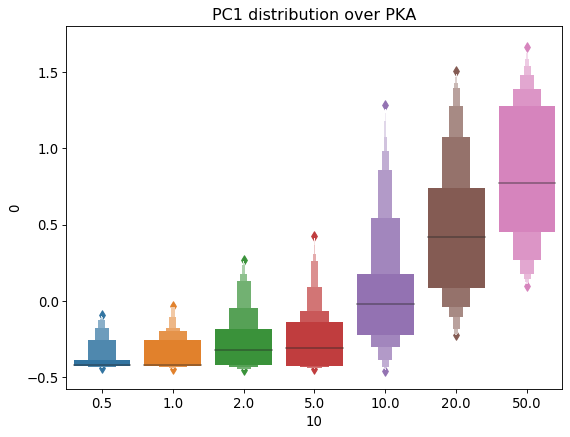

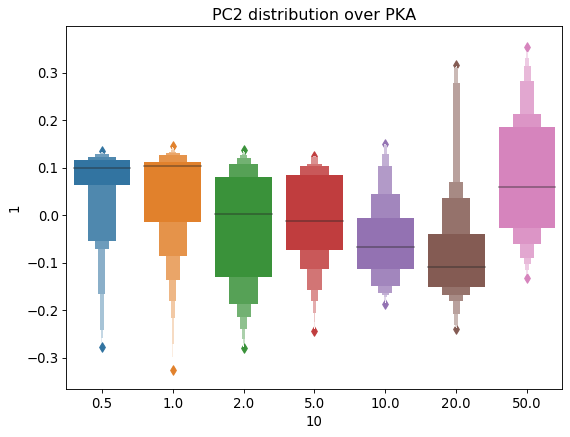

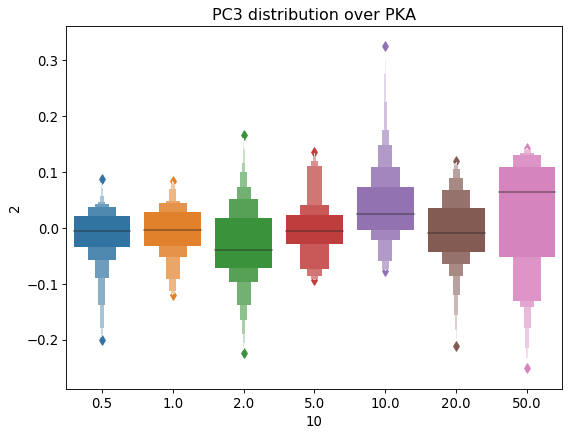

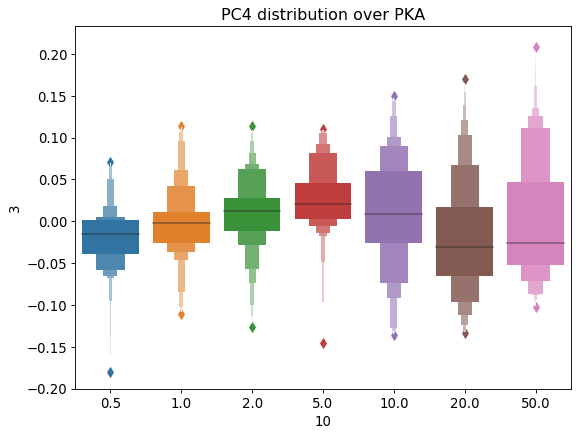

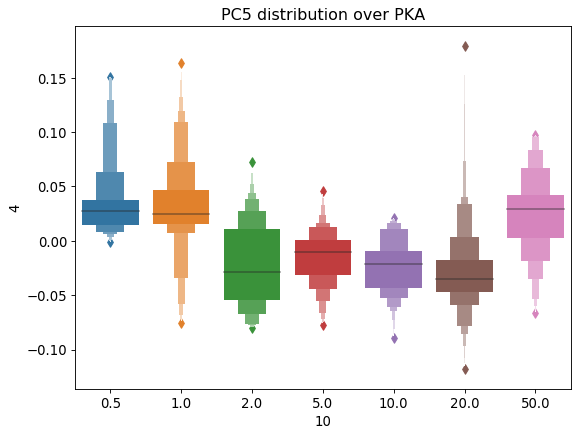

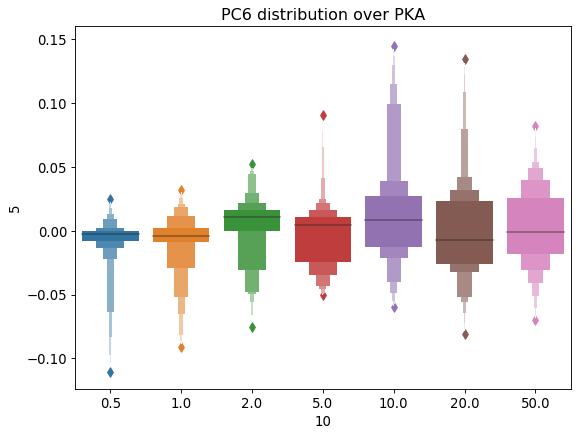

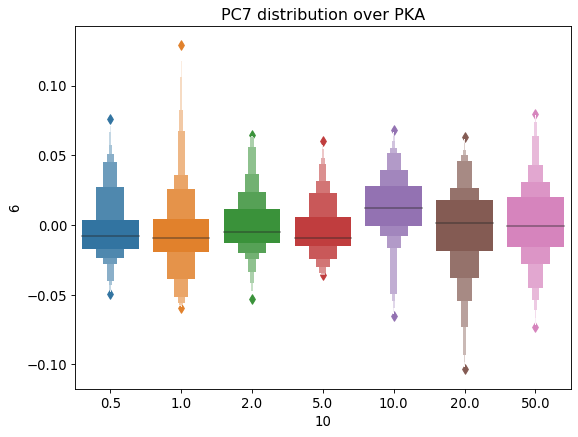

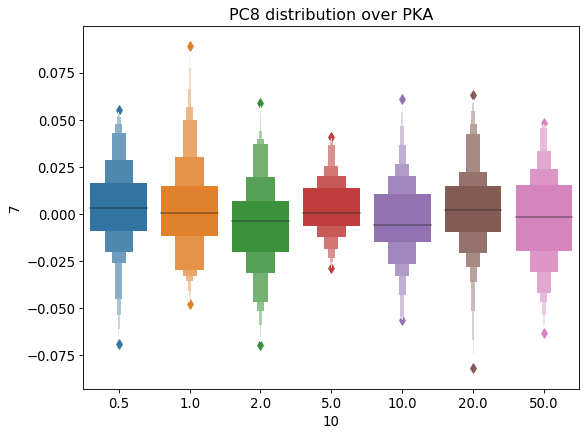

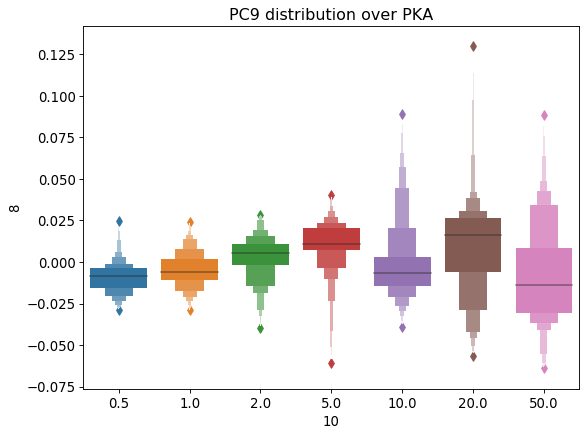

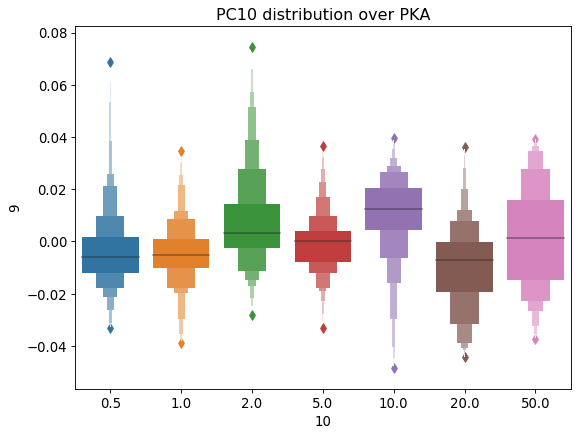

In [63]:
for i in range(10):
    ax = sns.boxenplot(x='10', y=str(i), data=df)
    plt.title("PC{} distribution over PKA".format(i+1))
    plt.show()

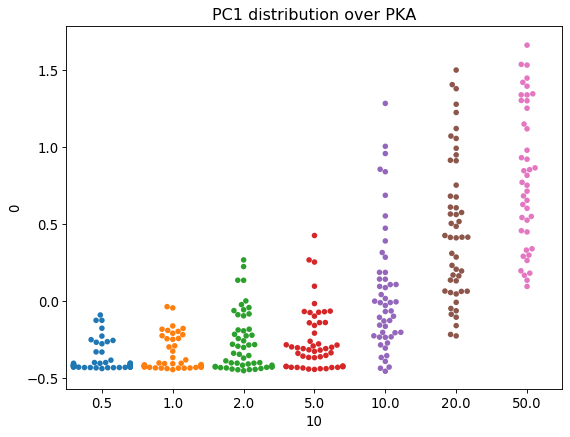

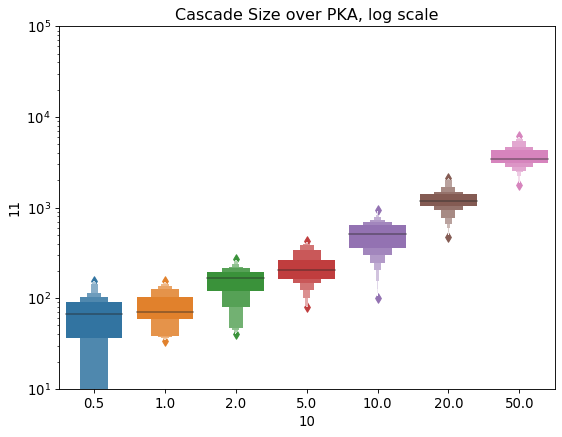

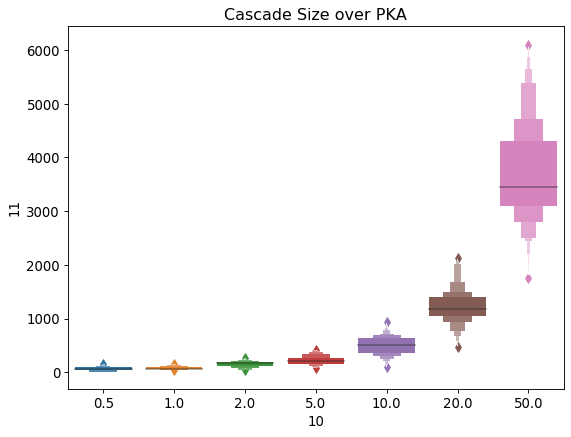

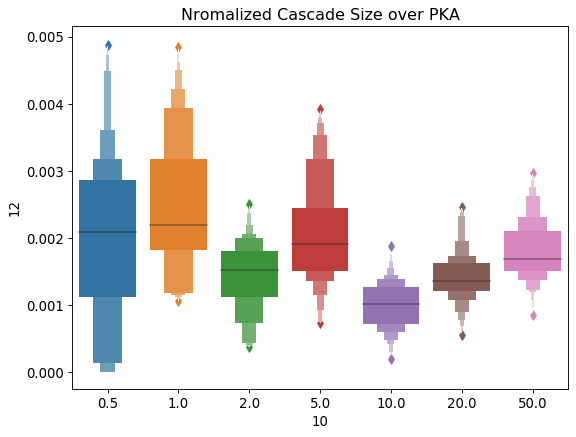

In [64]:
ax = sns.swarmplot(x='10', y='0', data=df)
plt.title("PC1 distribution over PKA")
plt.show()

ax = sns.boxenplot(x='10', y='11', data=df)
ax.set(yscale="log")
ax.set_ylim([10, 1e5])
plt.title("Cascade Size over PKA, log scale")
plt.show()

ax = sns.boxenplot(x='10', y='11', data=df)
plt.title("Cascade Size over PKA")
plt.show()

ax = sns.boxenplot(x='10', y='12', data=df)
plt.title("Nromalized Cascade Size over PKA")
plt.show()

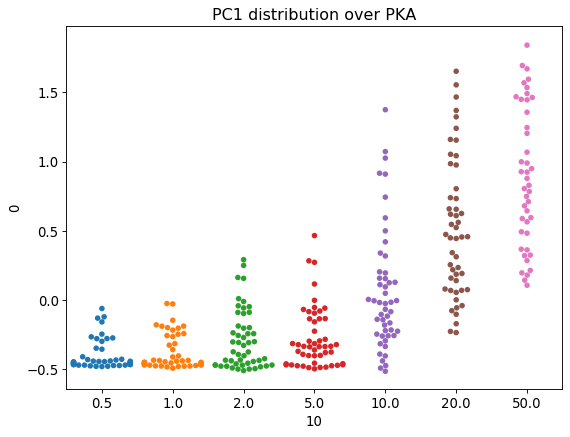

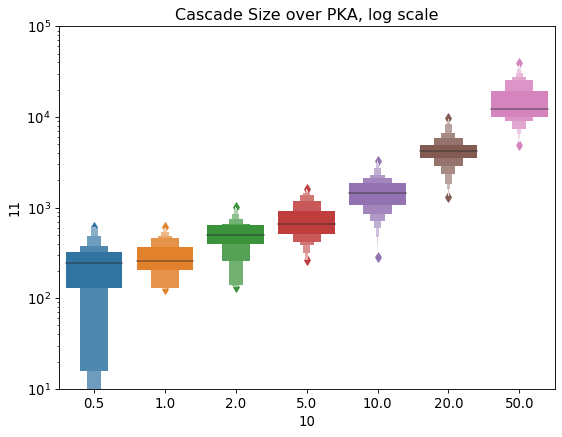

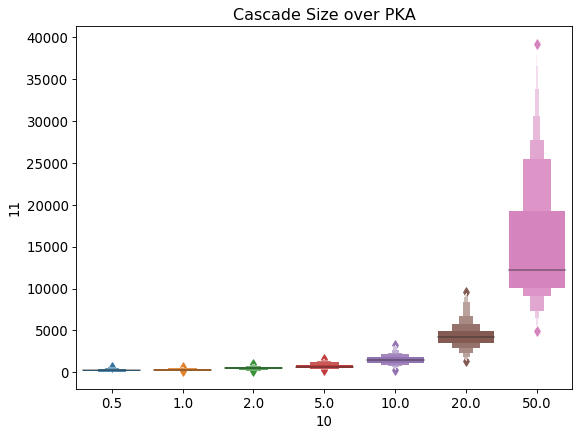

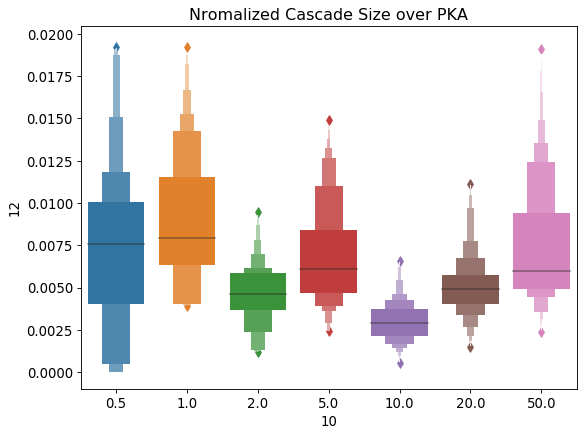

In [51]:
ax = sns.swarmplot(x='10', y='0', data=df)
plt.title("PC1 distribution over PKA")
plt.show()

ax = sns.boxenplot(x='10', y='11', data=df)
ax.set(yscale="log")
ax.set_ylim([10, 1e5])
plt.title("Cascade Size over PKA, log scale")
plt.show()

ax = sns.boxenplot(x='10', y='11', data=df)
plt.title("Cascade Size over PKA")
plt.show()

ax = sns.boxenplot(x='10', y='12', data=df)
plt.title("Nromalized Cascade Size over PKA")
plt.show()

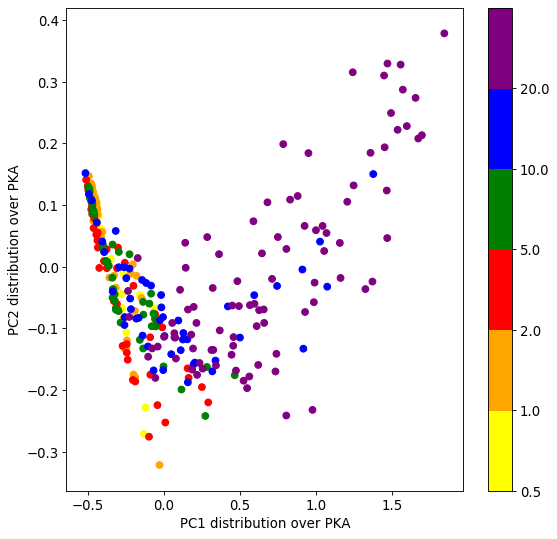

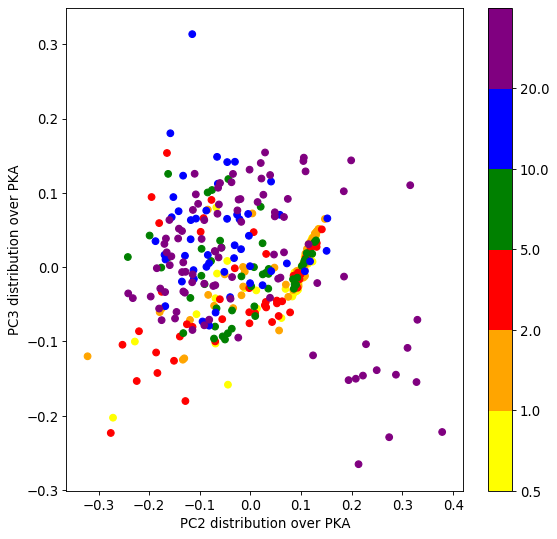

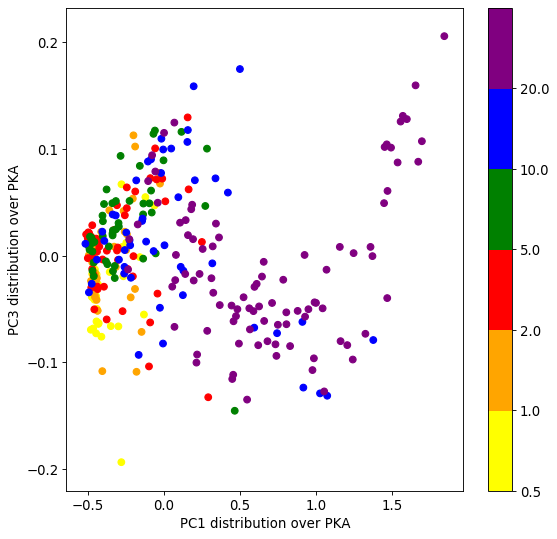

In [47]:
label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['yellow', 'orange', 'red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(scores[:,0], scores[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.xlabel("PC{} distribution over PKA".format(1))
plt.ylabel("PC{} distribution over PKA".format(2))
plt.show()


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['yellow', 'orange', 'red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(scores[:,1], scores[:,2], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.xlabel("PC{} distribution over PKA".format(2))
plt.ylabel("PC{} distribution over PKA".format(3))
plt.show()


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['yellow', 'orange', 'red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(scores[:,0], scores[:,3], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.xlabel("PC{} distribution over PKA".format(1))
plt.ylabel("PC{} distribution over PKA".format(3))
plt.show()

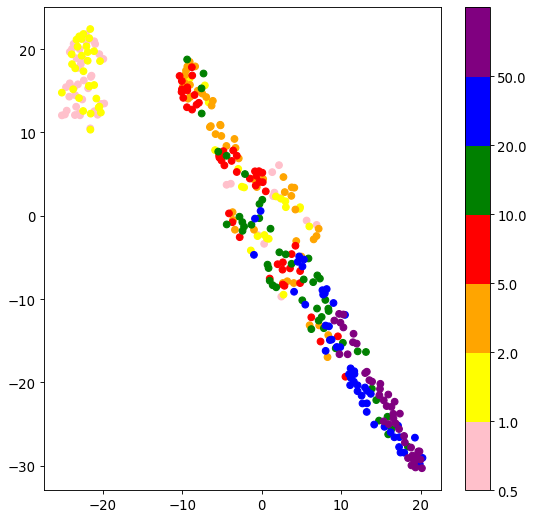

CPU times: user 12.8 s, sys: 140 ms, total: 13 s
Wall time: 1.12 s


In [64]:
%%time
X_emb = TSNE(n_components=2).fit_transform(x_data)


label = np.ravel([[i]*nrun for i in range(len(pka_list))])[indxs]
colors = ['pink', 'yellow', 'orange', 'red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])

plt.show()